<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_06_Logistic_Regression/IMDB_Dataset.csv
!ls -al data
!wc -l data/IMDB_Dataset.csv

2025-02-23 00:36:01 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_06_Logistic_Regression/IMDB_Dataset.csv [66212309/66212309] -> "data/IMDB_Dataset.csv" [1]
total 64672
drwxr-xr-x 2 root root     4096 Feb 23 00:36 .
drwxr-xr-x 1 root root     4096 Feb 23 00:36 ..
-rw-r--r-- 1 root root 66212309 Feb 23 00:36 IMDB_Dataset.csv
50001 data/IMDB_Dataset.csv


In [ ]:
import random
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

TOTAL_FRAMES=50
random.seed(20)

# Some functions to plot our points and draw the lines
def plot_points(features, labels, ax=None):
  X = np.array(features)
  y = np.array(labels)
  spam = X[np.argwhere(y==1)]
  ham = X[np.argwhere(y==0)]
  if ax is None:
    p=plt
    p.xlabel('ha')
    p.ylabel('boo')
  else:
    p=ax
    p.set_xlabel('ha')
    p.set_ylabel('boo')
  p.scatter([s[0][0] for s in spam],
            [s[0][1] for s in spam],
            s = 100,
            color = 'cyan',
            edgecolor = 'k',
            marker = '^')
  p.scatter([s[0][0] for s in ham],
            [s[0][1] for s in ham],
            s = 100,
            color = 'red',
            edgecolor = 'k',
            marker = 's')
  p.legend(['happy','sad'])

def draw_line(a,b,c, starting=0, ending=3, **kwargs):
  # Plotting the line ax + by + c = 0
  x = np.linspace(starting, ending, 1000)
  plt.plot(x, -c/b - a*x/b, **kwargs)

# Classification
[Youtube on Perceptron](https://www.youtube.com/watch?v=l-9ALe3U-Fg)

Regression models predict a number; whereas *classification* models predict a state or a category (drawing a line to separate our data points).

*Perceptron* uses linear regression and is building block of neuro net.

Instead of expressing a line with $y=mx+b$, we rewrite it into $w_1x_1+w_2x_2+b=0$
The line divides the plane into two zones with LHS>=0 being the positive zone, LHS<0 the negative zone.

If we want to flip the positive and negative zones, simplly change the sign of all the w and b in the equation.

Step function (a specific case of activation function):
* $step(x)=1 \text{ if } x\ge 0 $
* $step(x)=0 \text{ if } x\lt 0 $

The perceptron can be expressed with step function - the perceptron produces 1 if point is in positive zone; 0 if in negative zone:
$$\hat{y}=step(w_1x_1+w_2x_2+b)$$

The bias / intercept term basically gives the result for when w's are 0. i.e. in the alien sentiment example, it's the sentiment of a quiet alien (no words are said).

## Error function

Intuitively, we can sum up the distance of wrongly classified points and the dividing line. But this is not used because it's complicated to calculate the distance: the square root has complicated derivative.

So instead we use a *score* with these properties:
1. points on boundary, score=0
2. points in +zone, score>0
3. points in -zone, score<0
4. points close to boundary, |score| is small
5. points far from boundary, |score| is large

The *perceptron error* should be proportional to the distance between point and boundary. The perceptron for a point is defined as:
1. if point is correctly classified, error=0
2. if point is misclassified, perceptron error $PE=|w_1x_1+w_2x_2+\ldots+w_nx_n+b|=| w\cdotp x + b |=|\text{score}|$

The derivitives of the error:
* $\frac{\partial \text{error}}{\partial w}=x$, if $y=\hat y$; else, 0
* $\frac{\partial \text{error}}{\partial b}=1$, if $y=\hat y$; else, 0

The *mean perceptron error* (i.e. the error for entire dataset) = average of perceptron errors of all points.

**Gradient descent step** for Perceptron Error:
* $w'=w+(y-\hat y)\eta x$
* $b'=b+(y-\hat y)\eta$

Because $y$ and $\hat y$ are either 0 or 1, the $y-\hat y$ is one of -1, 0 or 1.

## Perceptron Algorithm

Using the happy/sad alien as an example. They have two words (Ha, Boo) in their vocab (i.e. features is 2-dim).

   Ha  Boo  Happy(1)/Sad(0)
0   1    0                0
1   0    2                0
2   1    1                0
3   1    2                0
4   1    3                1
5   2    2                1
6   2    3                1
7   3    2                1


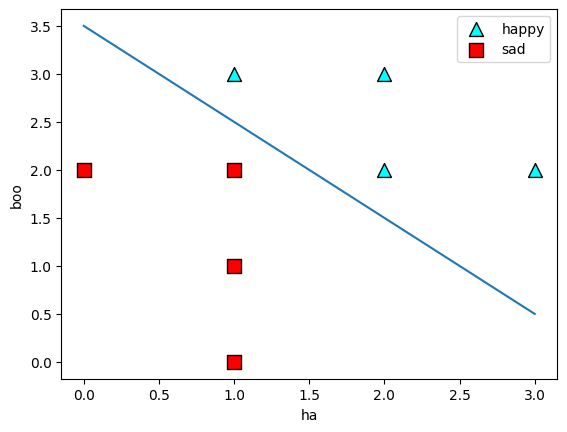

In [ ]:
# we have 8 data points and their labels in the dataset
batch_features = np.array([[1,0],[0,2],[1,1],[1,2],[1,3],[2,2],[2,3],[3,2]])
labels = np.array([0,0,0,0,1,1,1,1])

# printing the dataset in table
df = pd.DataFrame({
    'Ha' : batch_features[:,0],
    'Boo' : batch_features[:,1],
    'Happy(1)/Sad(0)': labels
})
print(df)

# Plotting the points
plot_points(batch_features, labels)

# Uncomment the following line to see a good line fit for this data.
draw_line(1,1,-3.5)

In [ ]:
#############
# m=batch size, n=vocab dim (num of words)
# weights: dim (n,)
# bias: scalar
# features: (n,)
# label: scalar
# batch_features: (m, n)
# labels: (m)
#############
def step(x):
  return 1 if x>=0 else 0

def score(weights, bias, features):
  return np.dot(features, weights) + bias

def prediction(weights, bias, features):
  return step(score(weights, bias, features))

def error(weights, bias, features, label):
  pred = prediction(weights, bias, features)
  if pred == label:
    return 0
  else:
    return np.abs(score(weights, bias, features))

def mean_perceptron_error(weights, bias, batch_features, labels):
  total_error = 0
  batch_size = len(batch_features) # number of points in the dataset
  for i in range(batch_size):
    total_error += error(weights, bias, batch_features[i], labels[i])

  return total_error / batch_size

# the back prop
def perceptron_trick(weights, bias, features, label, learning_rate = 0.01):
  pred = prediction(weights, bias, features)
  delta = (label-pred) * learning_rate
  n = len(weights)
  for i in range(n):
    weights[i] += delta * features[i]
  bias += delta
  return weights, bias

def perceptron_algorithm(batch_features, labels, learning_rate = 0.01, epochs=200):
  m = len(batch_features)
  n = len(batch_features[0])
  weights = [random.random() for i in range(n)]
  bias = random.random()
  Ws, bs, errs = [None] * epochs, [None] * epochs, [None] * epochs

  for epoch in range(epochs):
    error = mean_perceptron_error(weights, bias, batch_features, labels)

    i = random.randint(0, m-1) # Pick a random point in our dataset
    weights, bias = perceptron_trick(weights, bias, batch_features[i], labels[i])

    # preceptron_trick updates elements of weights list, so it's returning the
    # original list, so here we need to make a copy
    Ws[epoch] = weights.copy()
    bs[epoch] = bias
    errs[epoch]=error

    # print(f"o w={weights}, b={bias}")
    # print(f"x w={Ws[epoch]}, b={bs[epoch]}")

  return Ws, bs, errs

weights=[0.029923152866939858, 0.02595615591041223], bias=-0.10025481851754135
errors: max=1.01106637051034, min=0.0


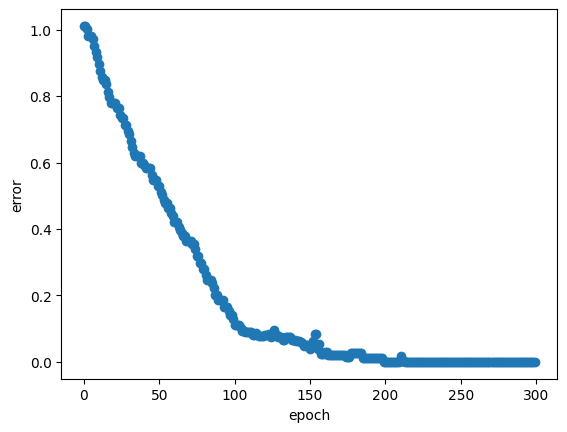

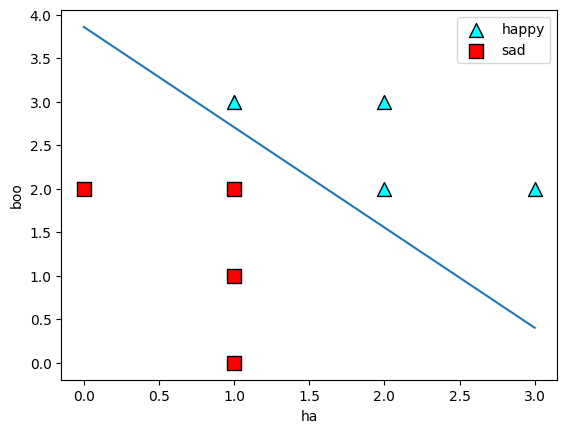

In [ ]:
epochs=300
Ws, bs, errs = perceptron_algorithm(batch_features, labels, learning_rate=0.01, epochs=epochs)
w = Ws[-1]
b = bs[-1]

print(f"weights={w}, bias={b}")
print(f"errors: max={max(errs)}, min={min(errs)}")

plt.scatter(np.arange(epochs), errs)
plt.xlabel('epoch')
plt.ylabel('error')
plt.show()

plot_points(batch_features, labels)
# Uncomment the following line to see a good line fit for this data.
draw_line(w[0],w[1],b)

In [ ]:
frames = np.linspace(0, epochs, TOTAL_FRAMES, dtype=np.uint32)
frames, len(frames)

(array([     0,   2040,   4081,   6122,   8163,  10204,  12244,  14285,
         16326,  18367,  20408,  22448,  24489,  26530,  28571,  30612,
         32653,  34693,  36734,  38775,  40816,  42857,  44897,  46938,
         48979,  51020,  53061,  55102,  57142,  59183,  61224,  63265,
         65306,  67346,  69387,  71428,  73469,  75510,  77551,  79591,
         81632,  83673,  85714,  87755,  89795,  91836,  93877,  95918,
         97959, 100000], dtype=uint32),
 50)

In [ ]:
# frames = np.logspace(0, np.log10(epochs), TOTAL_FRAMES, dtype=np.uint32)
# frames[:2] = 0
# frames, len(frames)
# frames = (epochs-frames)[::-1]

(array([  0,   0,   1,   1,   1,   1,   2,   2,   2,   2,   3,   3,   4,
          4,   5,   5,   6,   7,   8,   9,  10,  11,  12,  14,  16,  18,
         20,  23,  26,  29,  32,  36,  41,  46,  52,  58,  66,  74,  83,
         93, 105, 118, 132, 149, 167, 188, 211, 237, 267, 300],
       dtype=uint32),
 50)

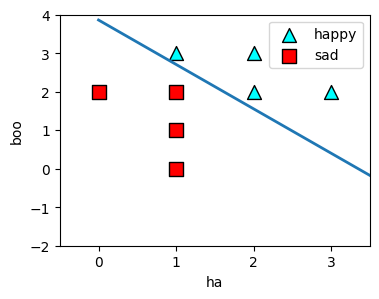

In [ ]:
# check the progress of the training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-2, 4)
plot_points(batch_features, labels, ax=ax)
line, = ax.plot([], [], lw=2)

def init():
  line.set_data([], [])
  return line,

def update(frame):
  idx = min(epochs-1, frames[frame])
  W = Ws[idx]
  b = bs[idx]
  w1, w2 = W[0], W[1]
  x = np.linspace(0, 10, 1000)
  y = -b/w2 - w1*x/w2
  line.set_data(x, y)
  return line,

ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, init_func=init, blit=True)
HTML(ani.to_jshtml())

## Perceptron using SKLearn

In [ ]:
model = Perceptron()
model.fit(batch_features, labels)
model.coef_, model.intercept_

(array([[4., 2.]]), array([-9.]))

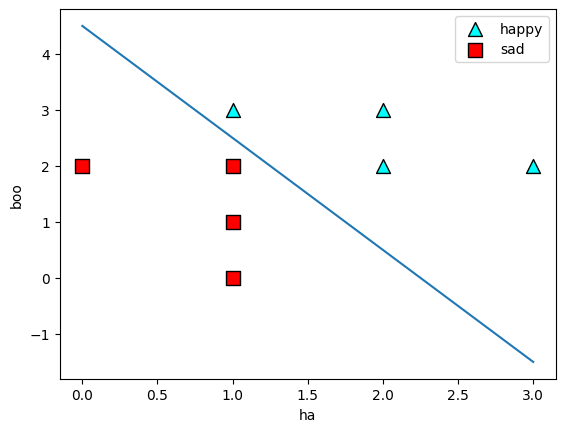

In [ ]:
plot_points(batch_features, labels)
draw_line(model.coef_[0,0], model.coef_[0,1], model.intercept_)

# Logistic Perceptron
The previous perceptron returns 1 or 0, they are called *discrete perceptron*. Perceptrons that return continuous values between 0 and 1 are *continuous perceptron*, or commonly called *logistic classifier*.

The output of logistic classifier can be considered a score:
* points with label 0 has score close to 0
* points with label 1 has score close to 1

The algo we use to train the logistic classifiers are called *logistic regression algo*:
$$\hat y=\sigma(w \cdot x + b)
$$

## Error function
1. absolute error - $|y-\hat y|$
2. square error - MAE, MSE, RMSE
3. log loss

1 and 2 are not commonly used for classification; 3 (log loss) is mostly used because it turns multiplication into addition. This is good because multiplication of many small numbers (0,1) become tiny numbers, which is a problem. But log of small number (0,1) just gives negative number, we negate them to make them positive.

Formula for log loss:
1. if label is 0, $\text{log loss} = -\ln(1-\hat y)$
2. if label is 1, $\text{log loss} = -\ln(\hat y)$

Because label y is either 1 or 0, the above can be condensed into: $\text{log loss} = -y\ln(\hat y)-(1-y)\ln(1-\hat y)$
Notice that the above equation is the definition of entropy of base 2: $H(p)=-p\log(p)-(1-p)\log(1-p)$. Therefore, the log loss is the entropy of the predicted probability distribution w.r.t. the true class labels.

The log loss of dataset is sum of log loss of each data point. **Note:** the log loss can never be zero.

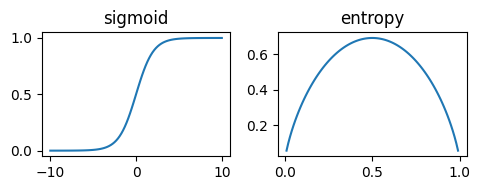

In [ ]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def log_loss(y, y_hat):
  return -y*math.log(y_hat)-(1-y)*math.log(1-y_hat)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5,2))
# plot sigmoid
xs = np.linspace(-10, 10, 100)
ax1.plot(xs, [sigmoid(x) for x in xs])
ax1.set_title('sigmoid')
# plot entropy
ps = np.linspace(0,1,100, endpoint=False)
ax2.plot(ps[1:], [log_loss(p,p) for p in ps[1:]])
ax2.set_title('entropy')

plt.tight_layout()
plt.show()

In [ ]:
# observe ln(x) behaviour: x->1, ln(x)->0; x->0 and x>0, then -ln(x) is large
-math.log(0.99), -math.log(0.0001)

(0.01005033585350145, 9.210340371976182)

In [ ]:
# use the above perceptron of 4x_1+2x_2-9
preds, losses = [], []
for i in range(len(batch_features)):
  features = batch_features[i]
  pred = sigmoid(4 * features[0] + 2 * features[1] -9)
  loss = log_loss(labels[i], pred)

  preds.append(pred)
  losses.append(loss)

# printing the dataset in table
df = pd.DataFrame({
    'Ha' : batch_features[:,0],
    'Boo' : batch_features[:,1],
    'Happy(1)/Sad(0)': labels,
    'prediction' : preds,
    'y-y_hat' : labels - preds,
    'log loss': losses
})
print(df)
print("total loss: ", sum(losses))

   Ha  Boo  Happy(1)/Sad(0)  prediction   y-y_hat  log loss
0   1    0                0    0.006693 -0.006693  0.006715
1   0    2                0    0.006693 -0.006693  0.006715
2   1    1                0    0.047426 -0.047426  0.048587
3   1    2                0    0.268941 -0.268941  0.313262
4   1    3                1    0.731059  0.268941  0.313262
5   2    2                1    0.952574  0.047426  0.048587
6   2    3                1    0.993307  0.006693  0.006715
7   3    2                1    0.999089  0.000911  0.000911
total loss:  0.7447555901050578


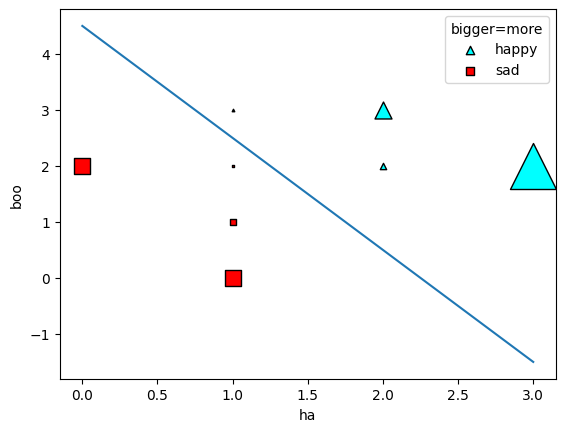

In [ ]:
def plot_logistic_points(batch_features, labels, losses, size_scale=1):
  for f, y, loss in zip(batch_features, labels, losses):
    if y==1:
      c, ec, m='cyan', 'k', '^'
    else:
      c,ec, m='red', 'k', 's'
    plt.scatter([f[0]], [f[1]], s=(1/loss*size_scale), color=c, edgecolor=ec, marker=m)
  plt.xlabel('ha')
  plt.ylabel('boo')
  handles = [
      plt.scatter([], [], color='cyan', edgecolors='k', marker='^', label='happy'),
      plt.scatter([], [], color='red', edgecolors='k', marker='s', label='sad')
  ]
  plt.legend(handles=handles, title='bigger=more')

plot_logistic_points(batch_features, labels, losses)
draw_line(4,2,-9)
plt.show()

## Logistic Regression Algo

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def score(weights, bias, features):
  return np.dot(weights, features) + bias

def prediction(weights, bias, features):
  return sigmoid(score(weights, bias, features))

def log_loss(weights, bias, features, label):
  pred = prediction(weights, bias, features)
  return -label*np.log(pred) - (1-label)*np.log(1-pred)

def total_log_loss(weights, bias, batch_features, labels):
  total_error = 0
  for i in range(len(batch_features)):
    total_error += log_loss(weights, bias, batch_features[i], labels[i])
  return total_error

def logistic_trick(weights, bias, features, label, learning_rate = 0.01):
  pred = prediction(weights, bias, features)
  delta = (label-pred)*learning_rate
  for i in range(len(weights)):
    weights[i] += delta*features[i]
  bias += delta
  return weights, bias

def logistic_regression_algorithm(batch_features, labels,
                                  learning_rate = 0.01, epochs = 1000):
  # plot_points(features, labels)
  # weights = [1.0 for i in range(len(features[0]))]
  # bias = 0.0
  # errors = []
  # for i in range(epochs):
  #   errors.append(total_log_loss(weights, bias, features, labels))
  #   j = random.randint(0, len(features)-1)
  #   weights, bias = logistic_trick(weights, bias, features[j], labels[j])
  # return weights, bias
  m = len(batch_features)
  n = len(batch_features[0])
  weights = [1.0 for i in range(n)]
  bias = 0.0
  Ws, bs, errs = [None] * epochs, [None] * epochs, [None] * epochs
  training_losses = []

  for epoch in range(epochs):
    epoch_losses = []
    error = total_log_loss(weights, bias, batch_features, labels)

    i = random.randint(0, m-1) # Pick a random point in our dataset
    weights, bias = logistic_trick(weights, bias, batch_features[i], labels[i])

    # logistic_trick updates elements of weights list, so it's returning the
    # original list, so here we need to make a copy
    Ws[epoch] = weights.copy()
    bs[epoch] = bias
    errs[epoch]=error

    for i in range(len(batch_features)):
      features = batch_features[i]
      loss = log_loss(weights, bias, features, labels[i])
      epoch_losses.append(loss)
    training_losses.append(epoch_losses)

  return Ws, bs, errs, training_losses

weights=[1.1630801891116291, 0.5725016844579323], bias=-2.33346600768227
errors: max=8.668198521798935, min=2.650772587309392
   Ha  Boo  Happy(1)/Sad(0)  prediction   y-y_hat  log loss
0   1    0                0    0.236785 -0.236785  0.270216
1   0    2                0    0.233534 -0.233534  0.265965
2   1    1                0    0.354828 -0.354828  0.438238
3   1    2                0    0.493655 -0.493655  0.680536
4   1    3                1    0.633467  0.366533  0.456547
5   2    2                1    0.757257  0.242743  0.278053
6   2    3                1    0.846862  0.153138  0.166217
7   3    2                1    0.908941  0.091059  0.095475
total loss:  2.651247834951169


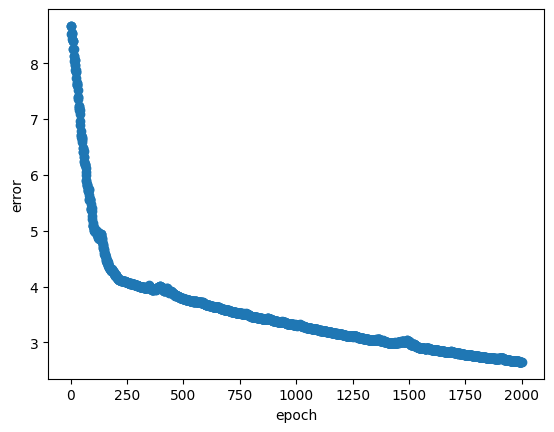

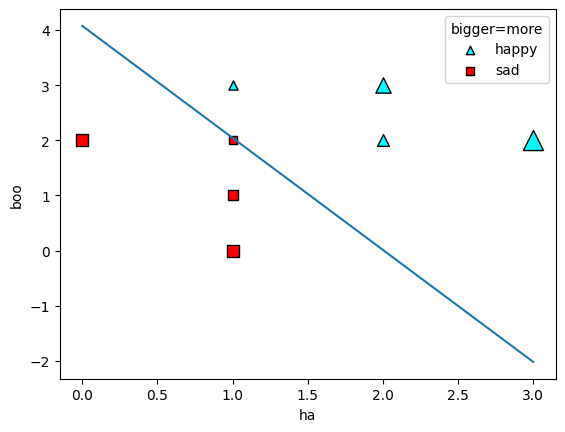

In [ ]:
epochs=2000
Ws, bs, errs, training_losses = logistic_regression_algorithm(batch_features, labels, learning_rate=0.01, epochs=epochs)
w = Ws[-1]
b = bs[-1]

print(f"weights={w}, bias={b}")
print(f"errors: max={max(errs)}, min={min(errs)}")

preds, losses = [], []
for i in range(len(batch_features)):
  features = batch_features[i]
  pred = prediction(w, b, features)
  loss = log_loss(w, b, features, labels[i])

  preds.append(pred)
  losses.append(loss)
# printing the dataset in table
df = pd.DataFrame({
    'Ha' : batch_features[:,0],
    'Boo' : batch_features[:,1],
    'Happy(1)/Sad(0)': labels,
    'prediction' : preds,
    'y-y_hat' : labels - preds,
    'log loss': losses
})
print(df)
print("total loss: ", sum(losses))

plt.scatter(np.arange(epochs), errs)
plt.xlabel('epoch')
plt.ylabel('error')
plt.show()

plot_logistic_points(batch_features, labels, losses, size_scale=20)
# Uncomment the following line to see a good line fit for this data.
draw_line(w[0],w[1],b)

In [ ]:
training_losses[10]

[1.270477904144331,
 2.0042423943662437,
 2.0288059013403257,
 2.8917278256819046,
 0.022533342803979364,
 0.021910654430365682,
 0.008557808861014682,
 0.008319713412158803]

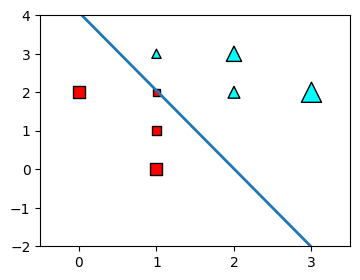

In [ ]:
frames = np.linspace(0, epochs, TOTAL_FRAMES, dtype=np.uint32)

# check the progress of the training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-2, 4)

line, = ax.plot([], [], lw=2)
pts_sad = ax.scatter([],[])
pts_happy = ax.scatter([],[])
pts_sad = ax.scatter(batch_features[:4,0], batch_features[:4,1], s=0, color='red', edgecolor='k', marker='s')
pts_happy = ax.scatter(batch_features[-4:,0], batch_features[-4:,1], s=0, color='cyan', edgecolor='k', marker='^')
################# animate points too #################

def init():
  line.set_data([], [])
  pts_sad.set_sizes(np.zeros(4))
  pts_happy.set_sizes(np.zeros(4))
  return line, pts_sad, pts_happy,

def update(frame):
  idx = min(epochs-1, frames[frame])
  W = Ws[idx]
  b = bs[idx]
  training_loss = np.array(training_losses[idx])
  w1, w2 = W[0], W[1]
  x = np.linspace(0, 10, 1000)
  y = -b/w2 - w1*x/w2
  line.set_data(x, y)

  pts_sad.set_sizes(1/training_loss[:4]*20)
  pts_happy.set_sizes(1/training_loss[-4:]*20)
  return line, pts_sad, pts_happy,

ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, init_func=init, blit=True)
HTML(ani.to_jshtml())

## IMDB example with SKLearn

In [ ]:
movies = pd.read_csv('data/IMDB_Dataset.csv')
movies

review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]

In [ ]:
movies['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
movies['sentiment'] = label_encoder.fit_transform(movies['sentiment'])
movies.head()

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(movies['review'], movies['sentiment'], test_size=0.3, random_state=42)

# below takes about 11 seconds
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)


In [ ]:
word_counts = X_train_vect.sum(axis=0)

In [ ]:
word_counts, idxs, idxs[0,-10:][0,::-1], word_counts[0,idxs[0,:10]]

(matrix([[153, 464,   2, ...,   1,   1,   1]]),
 matrix([[87996, 56392, 25128, ..., 54920,  3837, 77925]]),
 matrix([[77925,  3837, 54920, 78812, 40464, 10303, 40579, 38664, 78179,
          77903]]),
 matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))

In [ ]:
idxs = word_counts.argsort()
print("bottom 10 most frequent words: ", [f"{word}:{freq}" for word, freq
                                       in zip(vectorizer.get_feature_names_out()[idxs[0,:10]],
                                              word_counts[0,idxs[0,:10]])])
print("top 10 most frequent words: ", [f"{word}:{freq}" for word, freq
                                       in zip(vectorizer.get_feature_names_out()[idxs[0,-10:][0,::-1]],
                                              word_counts[0,idxs[0,-10:][0,::-1]])])
# note: [::-1] reverses the order

bottom 10 most frequent words:  ["['כרמון' 'oxenbuld' 'elsom' 'elsner' 'oxenburg' 'oxenby' 'oxenhope'\n 'oxfam' 'elsehere' 'oxidant']:[[1 1 1 1 1 1 1 1 1 1]]"]
top 10 most frequent words:  ["['the' 'and' 'of' 'to' 'is' 'br' 'it' 'in' 'this' 'that']:[[467008 226638 202172 187289 147702 141084 133776 130237 105660 100997]]"]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# preprocess the data with Std Scaler first, then feed into Logistic Regression
# pipe = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=200))
# pipe.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = pipe.predict(X_test)

model = LogisticRegression(max_iter=60) # max_iter default 100
model.fit(X_train_vect, y_train) # train the model (takes about 12sec / 100iter)
pipe = make_pipeline(vectorizer, model)
y_pred = model.predict(X_test_vect)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

Accuracy: 0.8919333333333334
Confusion Matrix:
 [[6547  864]
 [ 757 6832]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      7411
           1       0.89      0.90      0.89      7589

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
model.coef_.shape, model.intercept_, model.n_features_in_, X_train_vect.shape, model.get_params()

((1, 87997),
 array([-0.0734485]),
 87997,
 (35000, 87997),
 {'C': 1.0,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'l1_ratio': None,
  'max_iter': 60,
  'multi_class': 'deprecated',
  'n_jobs': None,
  'penalty': 'l2',
  'random_state': None,
  'solver': 'lbfgs',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False})

In [ ]:
vectorizer.max_df, vectorizer.min_df, vectorizer.max_features, vectorizer.get_feature_names_out().shape, \
vectorizer.get_feature_names_out()[:10], vectorizer.get_feature_names_out()[-10:]

(1.0,
 1,
 None,
 (87997,),
 array(['00', '000', '00000000000', '00000001', '00001', '000dm', '000s',
        '001', '003830', '007'], dtype=object),
 array(['übermenschlich', 'überwoman', 'ünel', 'üvegtigris', 'üzümcü',
        'ýs', 'þorleifsson', 'þór', 'יגאל', 'כרמון'], dtype=object))

In [ ]:
idxs = model.coef_.argsort().flatten()
print("top 10 low weight words: ", [f"{word}:{weight}" for word, weight
                                     in zip(vectorizer.get_feature_names_out()[idxs[:10]], model.coef_[0][idxs[:10]])])
print("top 10 high weight words:", [f"{word}:{weight}" for word, weight
                                   in zip(vectorizer.get_feature_names_out()[idxs[-10:][::-1]],model.coef_[0][idxs[-10:][::-1]])])

top 10 low weight words:  ['worst:-2.5735230175025814', 'waste:-1.9550700182067646', 'awful:-1.9117255928045693', 'boring:-1.667414550209814', 'terrible:-1.5283877878384724', 'dull:-1.3031148548147733', 'poor:-1.2960020783409645', 'poorly:-1.1668172896616429', 'worse:-1.1461385930034693', 'unfortunately:-1.0814577917069592']
top 10 high weight words: ['excellent:1.5873966683747494', 'amazing:1.2250005791211842', 'perfect:1.1865617691528227', 'brilliant:1.1739384119697092', 'wonderful:1.1632973538255578', 'hilarious:1.095585535571868', 'superb:0.9678899171801458', 'enjoyed:0.9433802359040308', 'favorite:0.9384198054870496', 'surprised:0.9086108452281064']


In [ ]:
idxs = np.where((model.coef_<1e-5) & (model.coef_>0))[1]
print("(close to) 0 weight words: ", [f"{word}:{weight}" for word, weight
                                     in zip(vectorizer.get_feature_names_out()[idxs], model.coef_[0][idxs])])

(close to) 0 weight words:  ['barmans:1.1550373611370697e-06', 'chantal:1.4352913637204097e-06', 'chilean:7.255216106296111e-06', 'compactor:6.507440852375205e-06', 'conveying:7.390755217228729e-06', 'demonico:4.965690674206835e-06', 'disliking:7.2856066093463e-06', 'dissipated:2.344284354399588e-06', 'environmentally:9.547490084350684e-06', 'muntean:2.8608513010289383e-06', 'ouroboros:5.416150034754247e-06', 'perversion:1.2434847776553979e-06', 'phoren:3.7014824594879986e-06', 'risking:2.672556850706392e-07', 'somethings:1.2098305796151305e-06', 'telepath:5.920198991138309e-06', 'verified:6.013377403111773e-06', 'yukio:9.570310826447512e-06']


In [ ]:
words = vectorizer.get_feature_names_out()
idxs = np.where(np.isin(words, ['this', 'that', 'the', 'very', 'from', 'tiny']))

print([f"{word}:{weight}" for word, weight
       in zip(vectorizer.get_feature_names_out()[idxs], model.coef_[0][idxs])])

['from:0.018014757876965562', 'that:-0.024361628705523344', 'the:0.01376670091689727', 'this:0.04336661885358871', 'tiny:-0.05344712161683682', 'very:0.03905958262598208']


In [ ]:
X_test

33553    I really liked this Summerslam due to the look...
9427     Not many television shows appeal to quite as m...
199      The film quickly gets to a major chase scene w...
12447    Jane Austen would definitely approve of this o...
39489    Expectations were somewhat high for me when I ...
                               ...                        
15168    "Landscape after a battle" opens with escaping...
49241    Jake Speed (1986) was an amusing parody of Ind...
39317    PLAN B has the appearance of a quickly made, u...
42191    One of the perks of my job is that when things...
15109    Once you can get past the film's title, "Pecke...
Name: review, Length: 15000, dtype: object

In [ ]:
idx=9427

print("review: ", X_test[idx])
print("prediction : ", pipe.predict([X_test[idx]]))
print("label      : ", y_test[idx])
print("probability: ", pipe.predict_proba([X_test[idx]]))

review:  Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you can think of that just adore this T.V miniseries. It has elements that can be found in almost every other show on T.V, character driven drama that could be from an Australian soap opera; yet in the same episode it has science fact & fiction that would give even the hardiest "Trekkie" a run for his money in the brainbender stakes! Wormhole theory, Time Travel in true equational form...Magnificent. It embraces cultures from all over the map as the possibilities are endless having multiple stars and therefore thousands of planets to choose from.<br /><br />With such a broad scope; it would be expected that nothing would be able to keep up the illusion for long, but here is where "Farscape" really comes into it's own element...It succeeds where all others have failed, especially the lik

In [ ]:
all_preds = pipe.predict_proba(movies['review'])

In [ ]:
movies['prediction']=all_preds[:,1]

In [ ]:
movies.sort_values('prediction')

review  sentiment  \
46198  Plankton, or Creatures from the Abyss as I'm p...          0   
1735   Komodo vs. Cobra starts as 'One Planet' enviro...          0   
4509   Attack Force has a horrendous title, and can a...          0   
16694  Okay wait let me get this street, there are ac...          0   
37205  I knew it was going to be awful but not this a...          0   
...                                                  ...        ...   
23330  This is one of the most underrated masterpiece...          1   
29425  By 1987 Hong Kong had given the world such fil...          1   
37277  This is a taut suspenseful masterpiece from Br...          1   
38816  This is an awesome Amicus horror anthology, wi...          1   
42946  By now you've probably heard a bit about the n...          1   

         prediction  
46198  1.537065e-21  
1735   5.088927e-20  
4509   3.888544e-19  
16694  4.559140e-19  
37205  7.990128e-19  
...             ...  
23330  1.000000e+00  
29425  1.000000e+00  
37277  1.000000e+00  
38816  1.000000e+00  
42946  1.000000e+00  

[50000 rows x 3 columns]

In [ ]:
movies.sort_values(by='prediction', ascending=False)

review  sentiment  \
42946  By now you've probably heard a bit about the n...          1   
37277  This is a taut suspenseful masterpiece from Br...          1   
38816  This is an awesome Amicus horror anthology, wi...          1   
29425  By 1987 Hong Kong had given the world such fil...          1   
23330  This is one of the most underrated masterpiece...          1   
...                                                  ...        ...   
37205  I knew it was going to be awful but not this a...          0   
16694  Okay wait let me get this street, there are ac...          0   
4509   Attack Force has a horrendous title, and can a...          0   
1735   Komodo vs. Cobra starts as 'One Planet' enviro...          0   
46198  Plankton, or Creatures from the Abyss as I'm p...          0   

         prediction  
42946  1.000000e+00  
37277  1.000000e+00  
38816  1.000000e+00  
29425  1.000000e+00  
23330  1.000000e+00  
...             ...  
37205  7.990128e-19  
16694  4.559140e-19  
4509   3.888544e-19  
1735   5.088927e-20  
46198  1.537065e-21  

[50000 rows x 3 columns]

In [ ]:
pipe.predict(['Unlike many terrible movies out there, this one is a surprisingly engaging, interesint and wonderful movie!'])

array([1])

# Classification into multiple classes

Normalise - dividing by their sum. This can be used for turning class scores into probabilities. But it does not work when score is negative.

So we need a function that always returns positive number. Any number's power will do: 2^x, 3^x, etc. but e^x is nice because its derivitive is also e^x.

So we use exp() for score for each class, then normalise them to get probabilities, i.e. *softmax* function:
$$P_i = \frac{e^{a_i}}{e^{a_1}+e^{a_2}+\ldots+e^{a_n}}
$$




# Evaluating Classification Models
Confusion matrix:

 actual condition | Predicted positive | Predicted negative |
----------|--------------------|--------------------|
**Positive** | true positives | false negatives |
**Negative** | false positives | true negatives |

measurements:
* Accuracy - in %, how often is the model right.
* Precision - among the cases we classified as positive, how many (%) are correct? $TruePositives=\frac{TruePositives}{TruePositives+FalsePositives}$
* Recall - among the positive examples, how many (%) did we correctly classify? $Recall=\frac{TruePositives}{TruePositives+FalseNegatives}$
* F-score - combining Precision and Recall: like average but closer to the minimum of the two
  * F1-score: *harmonic mean* of a, b = 2ab/(a+b). $F_1$ score: $F_1=\frac{2PR}{P+R}$
  * Fβ-score: β>0; β=0 => precision only; β=∞ => recall only. $F_\beta=\frac{(1+\beta^2)PR}{\beta^2P+R}$
* Sensitivity, Specificity -> receiver operating characteristic (ROC)
  * Sensitivity (true positive rate) - formula is same as Recall. In Corona visus model, we want high Sensitivity (want to detect positives)
  * Specificity (true negative rate): $Specificity=\frac{TrueNegatives}{TrueNegatives + FalsePositives}$ . In the spam email example, we want high specificity: i.e. we care more about sending ham emails to inbox.
  * ROC optimises sensitivi
* Area Under Curve (AUC): area under the ROC curve. The best a model can do is AUC=1; the worst is AUC=0.5 (as good as random)



In [ ]:
import plotly.graph_objects as go
import numpy as np

# Sample precision and recall values
precision = np.linspace(0, 1, 100)
recall = np.linspace(0, 1, 100)

# Create a meshgrid of precision and recall values
P, R = np.meshgrid(precision, recall)

# Function to calculate F-score
def f_score(P, R, beta):
    return (1 + beta**2) * (P * R) / (beta**2 * P + R)

# Calculate F-scores for different beta values
beta_values = [0.5, 1, 2]
f_scores = [f_score(P, R, beta) for beta in beta_values]

# Create the plot
fig = go.Figure()

for i, beta in enumerate(beta_values):
    fig.add_trace(go.Surface(z=f_scores[i], x=precision, y=recall, name=f'Beta = {beta}'))

# Add titles and labels
fig.update_layout(
    title='Effect of Beta on F-score',
    scene=dict(
        xaxis_title='Precision',
        yaxis_title='Recall',
        zaxis_title='F-score'
    )
)

# Show the plot
fig.show()

<ipython-input-2-1a6f0f6d4bbd>:13: RuntimeWarning: invalid value encountered in divide
  return (1 + beta**2) * (P * R) / (beta**2 * P + R)


In [ ]:
X_test.shape, y_test.shape, y_pred_proba, y_pred_proba[:,0]

((15000,),
 (15000,),
 array([[9.99595118e-01, 4.04881891e-04],
        [2.20016910e-01, 7.79983090e-01],
        [9.30380985e-01, 6.96190145e-02],
        ...,
        [9.99794432e-01, 2.05568331e-04],
        [1.02832954e-03, 9.98971670e-01],
        [3.11657226e-02, 9.68834277e-01]]),
 array([0.99959512, 0.22001691, 0.93038099, ..., 0.99979443, 0.00102833,
        0.03116572]))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# y_pred_proba is 2-d array: [[-prob, +prob], ...]
# to get positive prob, use [:,1]
y_pred_proba = pipe.predict_proba(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
# Calculate TNR (1 - FPR)
tnr = 1 - fpr

# Calculate AUC score
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc}")

AUC Score: 0.9556590715645485


In [ ]:
tpr, tnr, thresholds

(array([0.00000000e+00, 1.31769667e-04, 4.08485967e-02, ...,
        9.99868230e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.        , 1.        , 1.        , ..., 0.01605721, 0.01605721,
        0.        ]),
 array([           inf, 1.00000000e+00, 9.99990730e-01, ...,
        1.33191301e-08, 1.29115458e-08, 1.53706535e-21]))

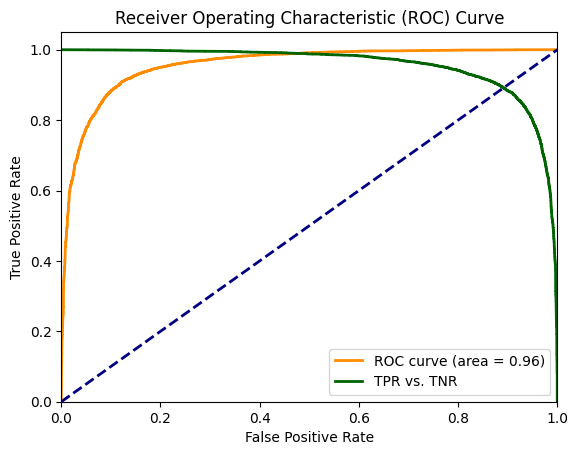

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot(tpr, tnr, color='darkgreen', lw=2, label='TPR vs. TNR')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()